In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit

### Define components of the algorithm

In [2]:
def phase_oracle(n, indices_to_mark, name = 'Oracle'):
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n, name=name)

    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1     
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

    # convert your matrix (called oracle_matrix) into an operator, and add it to the quantum circuit
    qc.unitary(Operator(oracle_matrix), range(n))
    
    return qc

In [3]:
def diffuser(n):
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n, name='Diffuser')
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    qc.h(range(n))
    qc.append(phase_oracle(n, [0]), range(n))
    qc.h(range(n))
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    
    return qc

### Construct algorithm using components

In [4]:
def Grover(n, indices_of_marked_elements):
    
    # Create a quantum circuit on n qubits
    qc = QuantumCircuit(n, n)
    
    # Determine r
    r = int(np.floor(np.pi/4*np.sqrt(2**n/len(indices_of_marked_elements))))
    print(f'{n} qubits, basis states {indices_of_marked_elements} marked, {r} rounds')
    
    # step 1: apply Hadamard gates on all qubits
    qc.h(range(n))
    
    # step 2: apply r rounds of the phase oracle and the diffuser
    for _ in range(r):
        qc.append(phase_oracle(n, indices_of_marked_elements), range(n))
        qc.append(diffuser(n), range(n))
        
    # step 3: measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

In [15]:
# Run for 4 qubits, for 1st and 9th indexed elements
mycircuit = Grover(4, [1, 9])
mycircuit.draw(output='text')

4 qubits, basis states [1, 9] marked, 2 rounds


┌───┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐┌─┐         
q_0: ┤ H ├┤0        ├┤0          ├┤0        ├┤0          ├┤M├─────────
     ├───┤│         ││           ││         ││           │└╥┘┌─┐      
q_1: ┤ H ├┤1        ├┤1          ├┤1        ├┤1          ├─╫─┤M├──────
     ├───┤│  Oracle ││  Diffuser ││  Oracle ││  Diffuser │ ║ └╥┘┌─┐   
q_2: ┤ H ├┤2        ├┤2          ├┤2        ├┤2          ├─╫──╫─┤M├───
     ├───┤│         ││           ││         ││           │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├┤3        ├┤3          ├┤3        ├┤3          ├─╫──╫──╫─┤M├
     └───┘└─────────┘└───────────┘└─────────┘└───────────┘ ║  ║  ║ └╥┘
c_0: ══════════════════════════════════════════════════════╩══╬══╬══╬═
                                                              ║  ║  ║ 
c_1: ═════════════════════════════════════════════════════════╩══╬══╬═
                                                                 ║  ║ 
c_2: ════════════════════════════════════════════════════════════╩══╬═
                                                                    ║ 
c_3: ═══════════════════════════════════════════════════════════════╩═

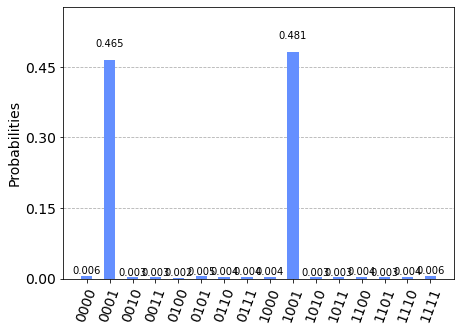

In [16]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [10]:
provider = IBMQ.load_account()
device = least_busy(provider.backends(simulator=False))
print("Running on current least busy device: ", device)

from qiskit.tools.monitor import job_monitor
job = execute(mycircuit, backend=device, shots=1000, max_credits=10)
job_monitor(job, interval = 2)

ibmqfactory.load_account:WARNING:2020-08-17 15:34:59,925: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmqx2
Job Status: job has successfully run


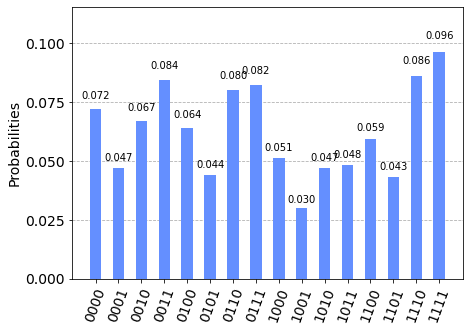

In [14]:
counts = job.result().get_counts()
plot_histogram(counts)

## Benchmarking runtime for simulator for only 1 indexed element

In [7]:
def p_even(lst):
    return [x for x in lst if not x % 2]

In [20]:
for n in p_even(range(2, 18)):
    test_circuit = Grover(n, [(n-1), (n-2)])
    
    # Import and define simulator
    from qiskit import Aer, execute
    simulator = Aer.get_backend('qasm_simulator')
    
    for i in range(5): 
        
        # Time the simulation runtime and store values
        benchmark_times = []
        
        import time
        start_time = time.time()

        counts = execute(test_circuit, backend=simulator, shots=1000).result().get_counts(test_circuit)

        benchmark_times.append(time.time() - start_time)
    
        print(str(n) + 'qubit times = ' + str(benchmark_times))

2 qubits, basis states [1, 0] marked, 1 rounds
2qubit times = [0.015990495681762695]
2qubit times = [0.01598644256591797]
2qubit times = [0.010997533798217773]
2qubit times = [0.012989521026611328]
2qubit times = [0.010993242263793945]
4 qubits, basis states [3, 2] marked, 2 rounds
4qubit times = [0.0179898738861084]
4qubit times = [0.013989686965942383]
4qubit times = [0.013992547988891602]
4qubit times = [0.013988971710205078]
4qubit times = [0.013993024826049805]
6 qubits, basis states [5, 4] marked, 4 rounds
6qubit times = [0.05196499824523926]
6qubit times = [0.05596303939819336]
6qubit times = [0.053461551666259766]
6qubit times = [0.05496358871459961]
6qubit times = [0.05738091468811035]
8 qubits, basis states [7, 6] marked, 8 rounds
8qubit times = [1.2892067432403564]
8qubit times = [1.1943256855010986]
8qubit times = [1.1532878875732422]
8qubit times = [1.325188159942627]
8qubit times = [1.6100106239318848]
10 qubits, basis states [9, 8] marked, 17 rounds
10qubit times = [79.7

KeyboardInterrupt: 

In [6]:
lst = [3, 5, 7, 9]

In [7]:
for n in lst:
    test_circuit = Grover(n, [(n-1), (n-2)])
    
    # Import and define simulator
    from qiskit import Aer, execute
    simulator = Aer.get_backend('qasm_simulator')
    
    for i in range(5): 
        
        # Time the simulation runtime and store values
        benchmark_times = []
        
        import time
        start_time = time.time()

        counts = execute(test_circuit, backend=simulator, shots=1000).result().get_counts(test_circuit)

        benchmark_times.append(time.time() - start_time)
    
        print(str(n) + 'qubit times = ' + str(benchmark_times))

3 qubits, basis states [2, 1] marked, 1 rounds
3qubit times = [0.02998042106628418]
3qubit times = [0.019985198974609375]
3qubit times = [0.018990516662597656]
3qubit times = [0.021986007690429688]
3qubit times = [0.015992164611816406]
5 qubits, basis states [4, 3] marked, 3 rounds
5qubit times = [0.035979270935058594]
5qubit times = [0.022983789443969727]
5qubit times = [0.02298569679260254]
5qubit times = [0.02697896957397461]
5qubit times = [0.02498626708984375]
7 qubits, basis states [6, 5] marked, 6 rounds
7qubit times = [0.2627902030944824]
7qubit times = [0.27782773971557617]
7qubit times = [0.2478475570678711]
7qubit times = [0.2878236770629883]
7qubit times = [0.27083539962768555]
9 qubits, basis states [8, 7] marked, 12 rounds
9qubit times = [11.342032194137573]
9qubit times = [11.949658155441284]
9qubit times = [11.171136140823364]
9qubit times = [10.8133544921875]
9qubit times = [11.579887628555298]
